# 1. Business Understanding

* newly renovated (less than 5 years) price prediction
* price prediction for investors (top 10 most expensive zip codes)

# 2. Data Mining

In [1377]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score



df = pd.read_csv("King_County_House_prices_dataset.csv")


In [1378]:
#sns.choose_colorbrewer_palette("qualitative")
#sns.set(style = "white", palette = sns.color_palette("Set1"))

In [1379]:
df.price.median()

450000.0

In [1380]:
df.floors

0        1.0
1        2.0
2        1.0
3        1.0
4        1.0
        ... 
21592    3.0
21593    2.0
21594    2.0
21595    2.0
21596    2.0
Name: floors, Length: 21597, dtype: float64

# 3. Data Cleaning

In [1381]:
df.isnull().sum().sort_values(ascending=False)

yr_renovated     3842
waterfront       2376
view               63
sqft_lot15          0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
condition           0
sqft_living15       0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
zipcode             0
lat                 0
long                0
id                  0
dtype: int64

What to predict: 
* price

What to ignore:
* id, date,

What to maybe ignore:
* lat,long, zip code
* view(has been viewed?)
* year renovated (many missing)

In [1382]:
df_clean = df.drop(["id","view"], axis = 1)


In [1384]:
df_clean

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,5/21/2014,360000.0,3,2.50,1530,1131,3.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,2/23/2015,400000.0,4,2.50,2310,5813,2.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,6/23/2014,402101.0,2,0.75,1020,1350,2.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


In [1358]:
df_clean.isnull().sum().sort_values(ascending=False)

yr_renovated     3842
waterfront       2376
sqft_lot15          0
condition           0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
grade               0
sqft_living15       0
sqft_above          0
sqft_basement       0
yr_built            0
zipcode             0
lat                 0
long                0
date                0
dtype: int64

In [1359]:
df_clean['sqft_basement'] = pd.to_numeric(df_clean['sqft_basement'],errors='coerce')
df_clean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 19 columns):
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21143 non-null float64
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(10), object(1)
memory usage: 3.1+ MB


# 5. Feature Engineering

## years since last renovation

In [1360]:
yr_sold=df_clean.date.str.extract("\/(.*)")[0].str.extract("\/(.*)")
yr_sold[0] = pd.to_numeric(yr_sold[0],errors='coerce')

In [1361]:
series = df_clean.yr_renovated - df_clean.yr_built
series[series < 0] = 0
df_clean["yr_since_renov"] = yr_sold[0] - df_clean.yr_built - series
df_clean = df_clean.drop(["yr_renovated"], axis = 1)
df_clean.yr_since_renov[df_clean["yr_since_renov"] < 0] = 0

/Users/karstenyan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [1362]:
df_clean.shape

(21597, 19)

## price/sqft_living

* kann ich nicht zum predicten benutzen, da ich dann die ziel größe in einem gewissen maße mit benutze, die ich beim out of sample test ja nicht kennen sollte (und deshalb auch nicht berechnen könnte bei frischen daten ohne preis)

In [1363]:
#df_clean["price_sqft_living"] = df_clean["price"]/df_clean["sqft_living"]

In [1364]:
#df_clean.head()

## Bathroom/Bedroom Ratio

In [1365]:
df_clean["br_br_ratio"] = df_clean["bedrooms"]/df_clean["bathrooms"]

## zip code price_rank areas

In [1366]:
arr1=[]
group_zip = df_clean.groupby("zipcode")
series = round(group_zip.price.mean())
series2 = {elm:idx for idx, elm in enumerate(sorted(series))}
zip_codes = list(df_clean.zipcode)

for elm in zip_codes:
    arr1.append(series2[series[elm]])

zip_averages = pd.Series(arr1)
zip_averages = zip_averages.rename("zip_ranks")
zip_averages

df_clean=df_clean.join(zip_averages)
df_clean.tail()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,...,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,yr_since_renov,br_br_ratio,zip_ranks
21592,5/21/2014,360000.0,3,2.50,1530,1131,3.0,0.0,3,8,...,0.0,2009,98103,47.6993,-122.346,1530,1509,5.0,1.200000,42
21593,2/23/2015,400000.0,4,2.50,2310,5813,2.0,0.0,3,8,...,0.0,2014,98146,47.5107,-122.362,1830,7200,1.0,1.600000,19
21594,6/23/2014,402101.0,2,0.75,1020,1350,2.0,0.0,3,7,...,0.0,2009,98144,47.5944,-122.299,1020,2007,5.0,2.666667,44
21595,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,3,8,...,0.0,2004,98027,47.5345,-122.069,1410,1287,11.0,1.200000,46
21596,10/15/2014,325000.0,2,0.75,1020,1076,2.0,0.0,3,7,...,0.0,2008,98144,47.5941,-122.299,1020,1357,6.0,2.666667,44


## Good Quality

In [1367]:
series = (df_clean["condition"] > 3) & (df_clean["grade"] > 7)
series=series*1
series=series.rename("good_quality")
df_clean=df_clean.join(series)

## Dummies

In [1368]:
df_clean = df_clean.join(pd.get_dummies(df_clean.grade, drop_first=True,prefix="Grade"))
df_clean = df_clean.drop(["grade"], axis = 1)

df_clean = df_clean.join(pd.get_dummies(df_clean.condition, drop_first=True, prefix="condition"))
df_clean = df_clean.drop(["condition"], axis = 1)

df_clean = df_clean.join(pd.get_dummies(df_clean.floors.astype("object"), drop_first=True, prefix="floors"))
df_clean = df_clean.drop(["floors"], axis = 1)

df_clean.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,sqft_above,sqft_basement,yr_built,...,Grade_13,condition_2,condition_3,condition_4,condition_5,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5
0,10/13/2014,221900.0,3,1.00,1180,5650,NaN,1180,0.0,1955,...,0,0,1,0,0,0,0,0,0,0
1,12/9/2014,538000.0,3,2.25,2570,7242,0.0,2170,400.0,1951,...,0,0,1,0,0,0,1,0,0,0
2,2/25/2015,180000.0,2,1.00,770,10000,0.0,770,0.0,1933,...,0,0,1,0,0,0,0,0,0,0
3,12/9/2014,604000.0,4,3.00,1960,5000,0.0,1050,910.0,1965,...,0,0,0,0,1,0,0,0,0,0
4,2/18/2015,510000.0,3,2.00,1680,8080,0.0,1680,0.0,1987,...,0,0,1,0,0,0,0,0,0,0


## cleanup

In [1369]:
df_clean = df_clean.drop(["date","zipcode","lat","long"], axis = 1)
df_clean=df_clean.dropna()
df_clean=df_clean.drop(index=15856)
df_clean.sort_values("bedrooms")

,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,sqft_above,sqft_basement,yr_built,sqft_living15,...,Grade_13,condition_2,condition_3,condition_4,condition_5,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5
9811,224000.0,1,0.75,840,7203,0.0,840,0.0,1949,1560,...,0,0,1,0,0,1,0,0,0,0
4828,285000.0,1,1.50,810,3211,0.0,810,0.0,1982,1320,...,0,0,0,1,0,0,1,0,0,0
11727,126000.0,1,1.00,610,4400,0.0,610,0.0,1922,1090,...,0,0,1,0,0,0,0,0,0,0
6556,269000.0,1,1.00,1020,7920,0.0,1020,0.0,1947,1000,...,0,0,1,0,0,0,0,0,0,0
2029,152900.0,1,1.00,900,4368,0.0,900,0.0,1915,1290,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4092,599999.0,9,4.50,3830,6988,0.0,2450,1380.0,1938,1460,...,0,0,1,0,0,0,0,1,0,0
13301,1150000.0,10,5.25,4590,10920,0.0,2500,2090.0,2008,2730,...,0,0,1,0,0,0,0,0,0,0
19239,660000.0,10,3.00,2920,3745,0.0,1860,1060.0,1913,1810,...,0,0,0,1,0,0,1,0,0,0
15147,650000.0,10,2.00,3610,11914,0.0,3010,600.0,1958,2040,...,0,0,0,1,0,0,1,0,0,0


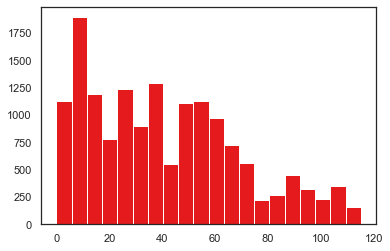

In [1370]:
plt.hist(df_clean.yr_since_renov, bins =20);

# 4. Data Exploration

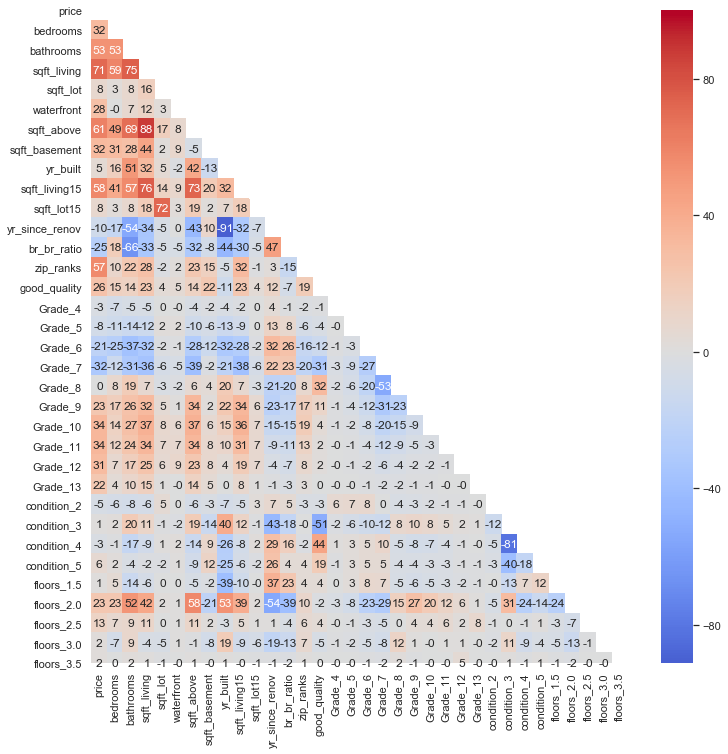

In [1371]:
plt.figure (figsize=(12,12))
mask = np.triu(df_clean.corr())
ax = sns.heatmap(round(df_clean.corr()*100)
                 ,annot=True
                 ,mask=mask
                 ,cmap='coolwarm'
                 ,center=0)
#ax.set_ylim((0,16))
#ax.set_xlim((0,16));

correlated with price:
* sqft above
* sqft living 15
* sqft living
* bathrooms
* bedrooms

autocorrelated:
* sqft_lot 15 with sqft_lot
* sqft_living with sqft_above and sqft_living and sqft_living 15

=> sqft_living, bathrooms, maybe bedrooms

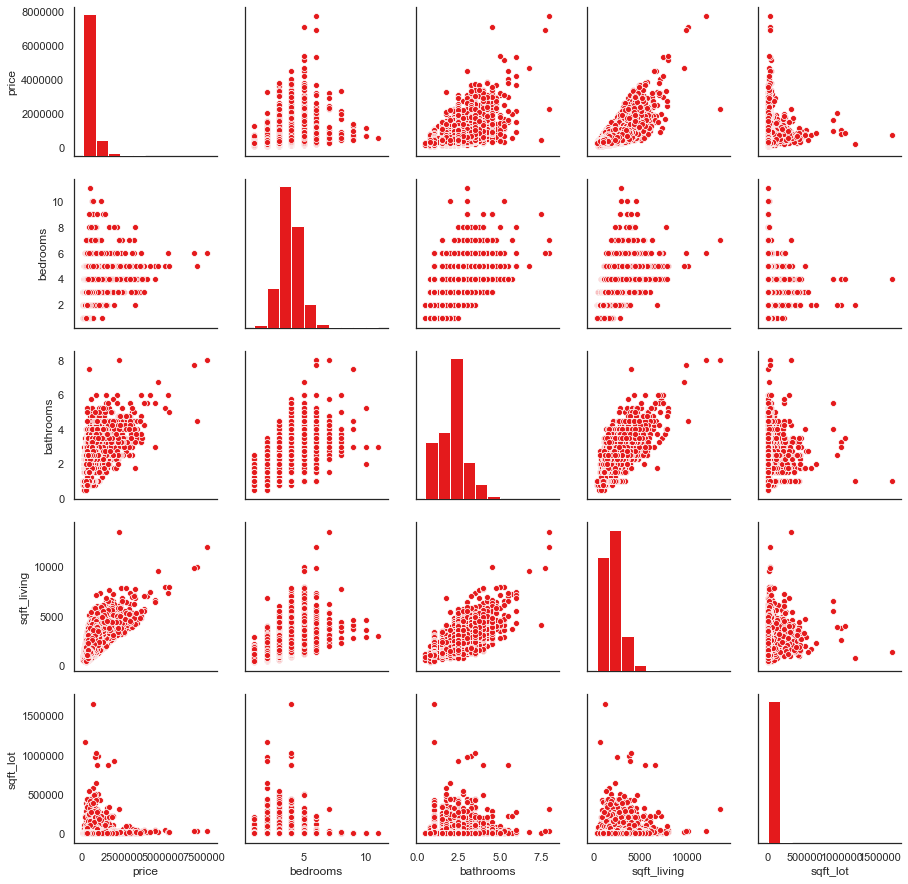

In [1372]:
colspp = ["price"]
colspp.extend(list(df_clean.columns[1:5]))
sns.pairplot(df_clean, vars=colspp);

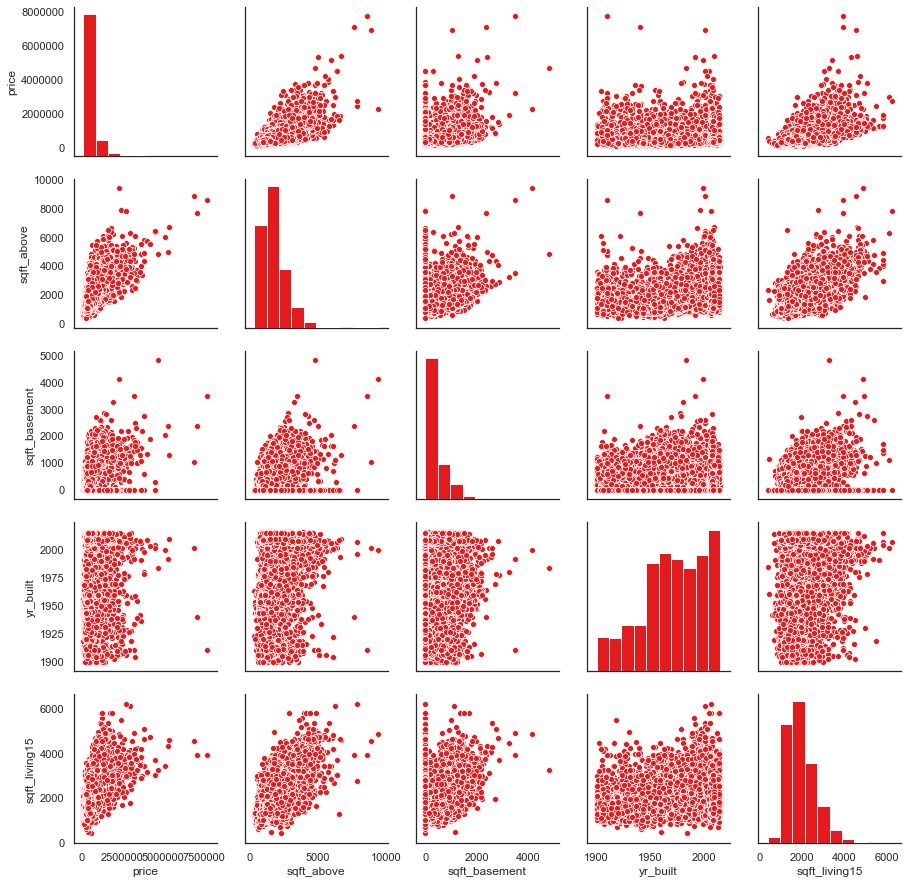

In [1373]:
colspp = ["price"]
colspp.extend(list(df_clean.columns[6:10]))
sns.pairplot(df_clean, vars=colspp);

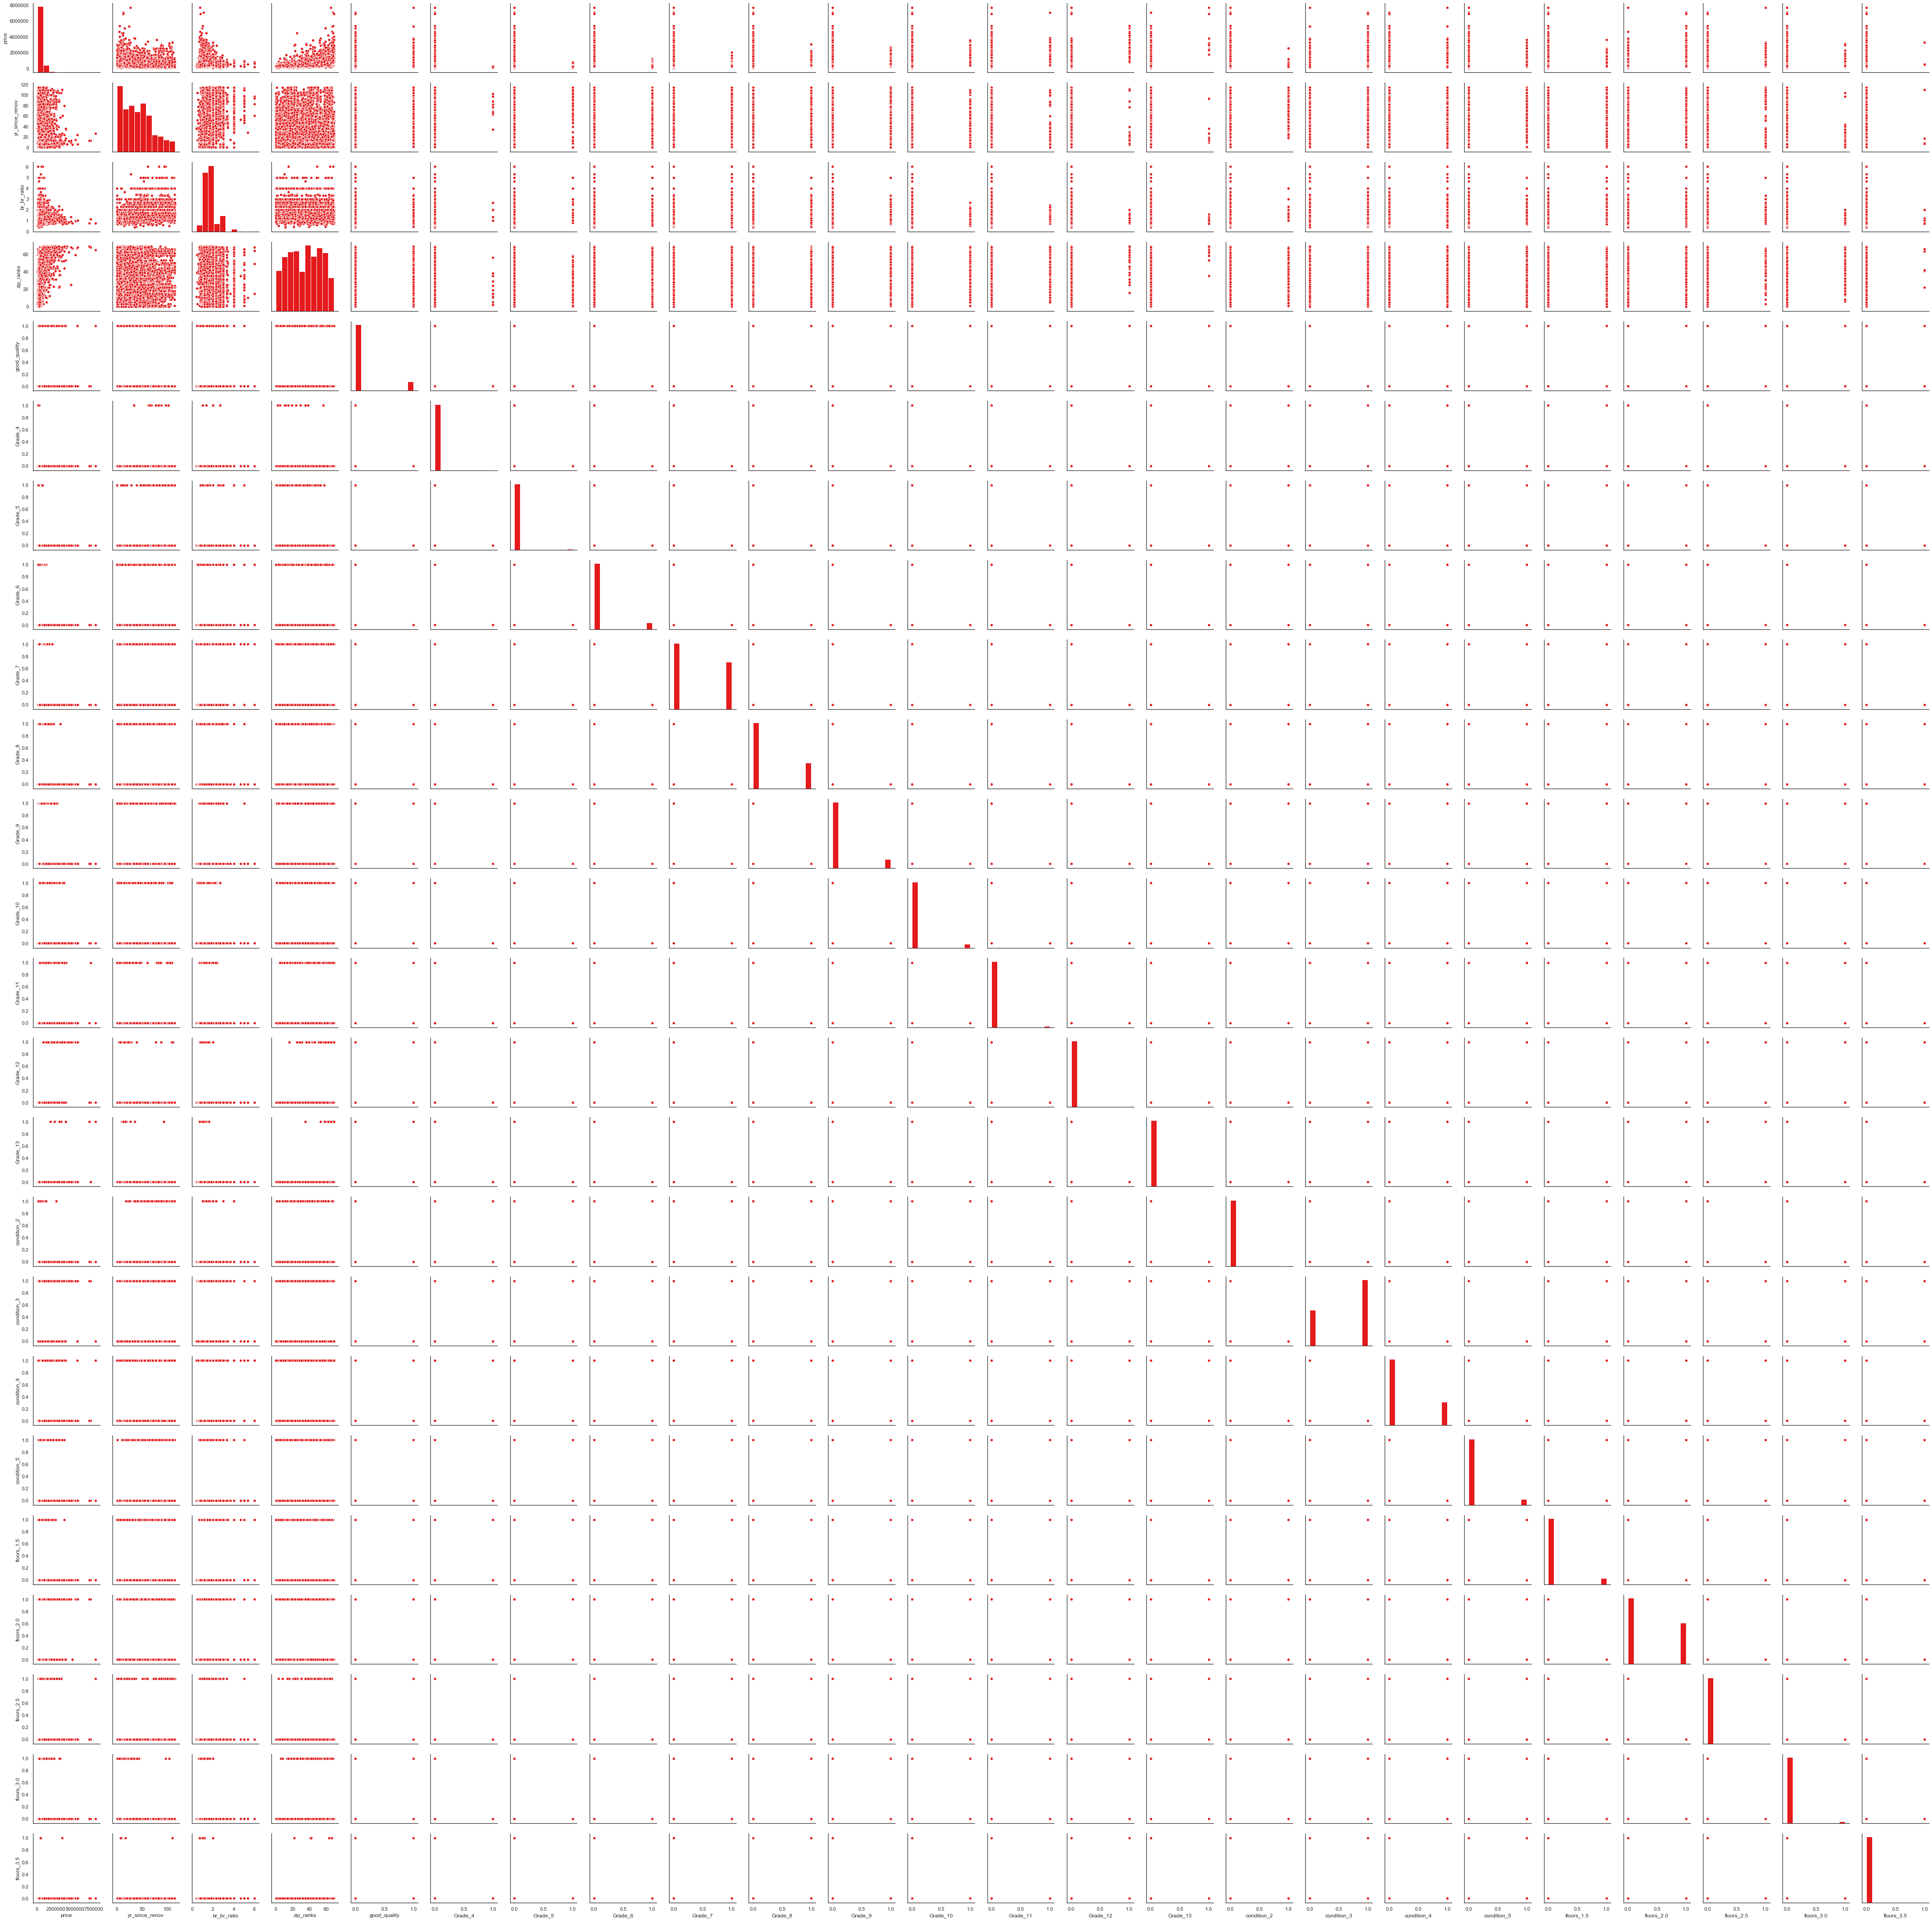

In [1374]:
colspp = ["price"]
colspp.extend(list(df_clean.columns[11:]))
sns.pairplot(df_clean, vars=colspp);

In [1375]:
plt.hist(df_clean.query("floors > 1 and waterfront == 0").price)
print(df_clean.query("floors > 1 and waterfront == 0").price.mean());

UndefinedVariableError: name 'floors' is not defined

In [ ]:
plt.hist(df_clean.query("floors > 1 and waterfront > 0").price)
print(df_clean.query("floors > 1 and waterfront > 0").price.mean());

In [ ]:
plt.hist(df_clean.query("floors == 1 and waterfront > 0").price)
print(df_clean.query("floors == 1 and waterfront > 0").price.mean());

In [ ]:
plt.scatter(x=df_clean.br_br_ratio, y=df_clean.price);

# 5. Feature Engineering

In [1345]:
renov_bins = pd.cut(df_clean.yr_since_renov, 5)
renov_bins = renov_bins.rename("renov_bins")
df_clean = df_clean.join(renov_bins)

In [1346]:
df_clean.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,sqft_above,sqft_basement,yr_built,sqft_living15,...,condition_2,condition_3,condition_4,condition_5,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,renov_bins
1,538000.0,3,2.25,2570,7242,0.0,2170,400.0,1951,1690,...,0,1,0,0,0,1,0,0,0,"(-0.115, 23.0]"
3,604000.0,4,3.00,1960,5000,0.0,1050,910.0,1965,1360,...,0,0,0,1,0,0,0,0,0,"(46.0, 69.0]"
4,510000.0,3,2.00,1680,8080,0.0,1680,0.0,1987,1800,...,0,1,0,0,0,0,0,0,0,"(23.0, 46.0]"
5,1230000.0,4,4.50,5420,101930,0.0,3890,1530.0,2001,4760,...,0,1,0,0,0,0,0,0,0,"(-0.115, 23.0]"
7,291850.0,3,1.50,1060,9711,0.0,1060,0.0,1963,1650,...,0,1,0,0,0,0,0,0,0,"(46.0, 69.0]"


# 6. Predictive Modeling

## 6.1. Alle Daten

In [1347]:
y = df_clean.price
X_train, X_test, y_train, y_test = train_test_split(df_clean, y, test_size=0.2)

In [1348]:
cols = list(df_clean.columns)
cols.append("")
cols.pop(cols.index("price"))
cols.pop(cols.index("renov_bins"))
formula_list = []
nkey = ""
formula = "price ~ "
n=0
while len(cols) > 0:
    formula += nkey + " + "
    cols.pop(cols.index(nkey))
    a = {elm : smf.ols(formula=formula+ " "+elm, data=X_train).fit().rsquared_adj for elm in cols}
    for key, value in a.items():
        if  value == max(a.values()):
            nkey = key
            formula_list.append(key)
            print(str(n) + ":"+key + ": rsquared_adj: " + str(value))
            n+=1

SyntaxError: invalid syntax (<unknown>, line 1)

In [1169]:
formula = "price ~ "+" + ".join(formula_list[0:13])
print(formula)

price ~ sqft_living + zip_ranks + waterfront + Grade_12 + yr_built + Grade_11 + Grade_10 + Grade_9 + Grade_13 + bathrooms + good_quality + bedrooms + br_br_ratio


In [1170]:
smf.ols(formula=formula, data=X_train).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     3190.
Date:                Wed, 04 Mar 2020   Prob (F-statistic):               0.00
Time:                        16:28:15   Log-Likelihood:            -1.6689e+05
No. Observations:               12378   AIC:                         3.338e+05
Df Residuals:                   12364   BIC:                         3.339e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     3.325e+06   1.31e+05     25.436      0.000    3.07e+06    3.58e+06
sqft_living    147.1537      3.545     41.507      0.000     140.204     154.103
zip_ranks     6864.5012     89.378     76.803      0.000    6689.306    7039.697
waterfront    7.634e+05   1.83e+04     41.800      0.000    7.28e+05    7.99e+05
Grade_12      1.017e+06   2.63e+04     38.721      0.000    9.66e+05    1.07e+06
yr_built     -1797.0980     66.262    -27.121      0.000   -1926.982   -1667.214
Grade_11      3.831e+05   1.35e+04     28.483      0.000    3.57e+05    4.09e+05
Grade_10      2.339e+05   8548.464     27.360      0.000    2.17e+05    2.51e+05
Grade_9       1.027e+05   5634.818     18.233      0.000    9.17e+04    1.14e+05
Grade_13      1.136e+06    6.7e+04     16.958      0.000       1e+06    1.27e+06
bathrooms     1.114e+05   6550.560     16.999      0.000    9.85e+04    1.24e+05
good_quality  6.378e+04   5076.404     12.565      0.000    5.38e+04    7.37e+04
bedrooms     -5.488e+04   3972.977    -13.812      0.000   -6.27e+04   -4.71e+04
br_br_ratio    6.46e+04   6134.765     10.531      0.000    5.26e+04    7.66e+04
==============================================================================
Omnibus:                     7340.880   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           257497.985
Skew:                           2.273   Prob(JB):                         0.00
Kurtosis:                      24.877   Cond. No.                     2.47e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.47e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

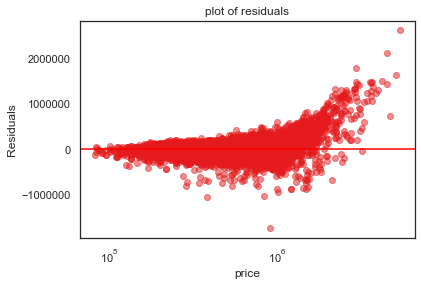

In [1171]:
plt.scatter(x=X_train.price, y=smf.ols(formula=formula, data=X_train).fit().resid, alpha = 0.5)
plt.title("plot of residuals")
plt.axhline(color='r')
plt.ylabel("Residuals")
plt.xlabel("price")
plt.xscale("log");


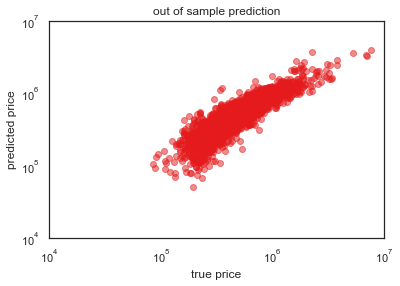

In [1172]:
y_pred = smf.ols(formula=formula, data = X_train).fit().predict(X_test)
plt.scatter(x=y_test, y=y_pred, alpha = 0.5)
plt.ylabel("predicted price")
plt.xlabel("true price")
plt.title("out of sample prediction")
plt.xscale("log")
plt.yscale("log")
plt.ylim(10000,10000000)
plt.xlim(10000,10000000);
                 



In [1173]:
print("Mean Error (less is better):" + str(np.sqrt(mean_squared_error(y_test, y_pred))))
print("R2 score (closer to 1 is better):" + str(r2_score(y_test, y_pred)))

print("proportion of error to price mean:"+str((np.sqrt(mean_squared_error(y_test, y_pred))/df_clean.price.mean())*100))

Mean Error (less is better):208120.09394869558
R2 score (closer to 1 is better):0.7569355475178157
proportion of error to price mean:38.41597593226694


## 6.2 Prediction for newly renovated houses

In [1376]:
df_clean.query("yr_since_renov <= 5")

,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,sqft_above,sqft_basement,yr_built,sqft_living15,...,Grade_13,condition_2,condition_3,condition_4,condition_5,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5
63,549000.0,3,1.75,1540,1044,0.0,1540,0.0,2014,1580,...,0,0,1,0,0,0,0,0,1,0
103,1090000.0,3,2.50,2920,8113,0.0,2920,0.0,1950,2370,...,0,0,1,0,0,0,1,0,0,0
116,518500.0,3,3.50,1590,1102,0.0,1590,0.0,2010,1620,...,0,0,1,0,0,0,0,0,1,0
133,453246.0,3,2.50,2010,2287,0.0,1390,620.0,2014,1690,...,0,0,1,0,0,0,1,0,0,0
158,247000.0,3,2.00,1270,7198,0.0,1270,0.0,1916,1160,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21588,429000.0,3,2.00,1490,1126,0.0,1490,0.0,2014,1400,...,0,0,1,0,0,0,0,0,1,0
21589,610685.0,4,2.50,2520,6023,0.0,2520,0.0,2014,2520,...,0,0,1,0,0,0,1,0,0,0
21592,360000.0,3,2.50,1530,1131,0.0,1530,0.0,2009,1530,...,0,0,1,0,0,0,0,0,1,0
21593,400000.0,4,2.50,2310,5813,0.0,2310,0.0,2014,1830,...,0,0,1,0,0,0,1,0,0,0


In [1174]:
y = df_clean.query("yr_since_renov <= 5").price
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_clean.query("yr_since_renov <= 5"), y, test_size=0.2)

In [1175]:
cols = list(df_clean.columns)
cols.append("")
cols.pop(cols.index("price"))
cols.pop(cols.index("yr_since_renov"))
cols.pop(cols.index("renov_bins"))
cols.pop(cols.index("yr_built"))
nkey = ""
formula = "price ~ "
formula_list = []
n=0
while len(cols) > 0:
    formula += nkey + " + "
    cols.pop(cols.index(nkey))
    a = {elm : smf.ols(formula=formula+ " "+elm, data=X_train2).fit().rsquared_adj for elm in cols}
    for key, value in a.items():
        if  value == max(a.values()):
            nkey = key
            formula_list.append(key)
            print(str(n) + ":"+key + ": rsquared_adj: " + str(value))
            n+=1

0:sqft_living: rsquared_adj: 0.4809952731632626
1:zip_ranks: rsquared_adj: 0.6614683052837462
2:Grade_11: rsquared_adj: 0.7180747305969304
3:waterfront: rsquared_adj: 0.7542485245927641
4:Grade_10: rsquared_adj: 0.7783740018224716
5:sqft_living15: rsquared_adj: 0.7952088851768357
6:bathrooms: rsquared_adj: 0.7990608317615967
7:Grade_9: rsquared_adj: 0.8026385121655679
8:Grade_12: rsquared_adj: 0.8055732063240704
9:sqft_lot15: rsquared_adj: 0.8076787931438414
10:sqft_above: rsquared_adj: 0.8080826471716228
11:sqft_basement: rsquared_adj: 0.8080826471716228
12:br_br_ratio: rsquared_adj: 0.8083837970695582
13:bedrooms: rsquared_adj: 0.810443170535174
14:sqft_above: rsquared_adj: 0.810443170535174
15:Grade_4: rsquared_adj: 0.810443170535174
16:Grade_13: rsquared_adj: 0.810443170535174
17:condition_2: rsquared_adj: 0.810443170535174
18:sqft_above: rsquared_adj: 0.810443170535174
19:Grade_4: rsquared_adj: 0.810443170535174
20:Grade_13: rsquared_adj: 0.810443170535174
21:sqft_above: rsquared_

In [1176]:
formula = "price ~ "+" + ".join(formula_list[0:11])
print(formula)

price ~ sqft_living + zip_ranks + Grade_11 + waterfront + Grade_10 + sqft_living15 + bathrooms + Grade_9 + Grade_12 + sqft_lot15 + sqft_above


In [1177]:
smf.ols(formula=formula, data=X_train2).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     346.7
Date:                Wed, 04 Mar 2020   Prob (F-statistic):          5.02e-313
Time:                        16:28:55   Log-Likelihood:                -12205.
No. Observations:                 904   AIC:                         2.443e+04
Df Residuals:                     892   BIC:                         2.449e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.468e+05   3.25e+04     -4.511      0.000   -2.11e+05   -8.29e+04
sqft_living     227.2693     19.247     11.808      0.000     189.494     265.044
zip_ranks      8153.3140    353.749     23.048      0.000    7459.036    8847.592
Grade_11       9.789e+05    5.8e+04     16.871      0.000    8.65e+05    1.09e+06
waterfront     1.206e+06   1.87e+05      6.455      0.000     8.4e+05    1.57e+06
Grade_10       3.146e+05   2.62e+04     12.015      0.000    2.63e+05    3.66e+05
sqft_living15   -86.6318     12.028     -7.202      0.000    -110.238     -63.025
bathrooms      5.485e+04   1.36e+04      4.038      0.000    2.82e+04    8.15e+04
Grade_9        7.188e+04   1.57e+04      4.565      0.000     4.1e+04    1.03e+05
Grade_12       9.498e+05   2.72e+05      3.495      0.000    4.16e+05    1.48e+06
sqft_lot15       -2.0174      0.600     -3.363      0.001      -3.195      -0.840
sqft_above      -29.5617     17.422     -1.697      0.090     -63.755       4.631
==============================================================================
Omnibus:                      534.884   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10389.796
Skew:                           2.301   Prob(JB):                         0.00
Kurtosis:                      18.958   Cond. No.                     6.66e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.66e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

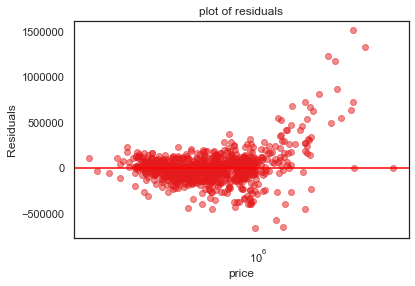

In [1178]:
plt.scatter(x=X_train2.price, y=smf.ols(formula=formula, 
                                        data=X_train2).fit().resid, alpha = 0.5)
plt.title("plot of residuals")
plt.axhline(color='r')
plt.ylabel("Residuals")
plt.xlabel("price")
plt.xscale("log");

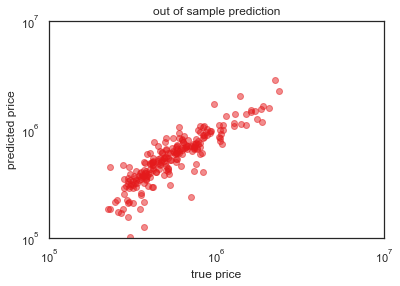

In [1179]:

y_pred2 = smf.ols(formula=formula, 
                  data=X_train2).fit().predict(X_test2)
plt.scatter(x=y_test2, y=y_pred2, alpha = 0.5)
plt.ylabel("predicted price")
plt.xlabel("true price")
plt.title("out of sample prediction")
plt.xscale("log")
plt.yscale("log")
plt.ylim(100000,10000000)
plt.xlim(100000,10000000);

In [1180]:
print("Mean Error (less is better):" + str(np.sqrt(mean_squared_error(y_test2, y_pred2))))
print("R2 score (closer to 1 is better):" + str(r2_score(y_test2, y_pred2)))

print("proportion of error to price mean:"+str((np.sqrt(mean_squared_error(y_test2, y_pred2))/df_clean.query("yr_since_renov <= 5").price.mean())*100))

Mean Error (less is better):167091.37779169175
R2 score (closer to 1 is better):0.8019192303035074
proportion of error to price mean:26.30868270602952


## 6.3 Prediction für beste (teuerste) Gegend

In [1181]:
best_areas = df_clean[df_clean["zip_ranks"] >= sorted(list(df_clean.zip_ranks.unique()))[-10]]

In [1182]:
y = best_areas.price
X_train3, X_test3, y_train3, y_test3 = train_test_split(best_areas, y, test_size=0.2)

In [1183]:
cols = list(df_clean.columns)
cols.append("")
cols.pop(cols.index("price"))
cols.pop(cols.index("zip_ranks"))
cols.pop(cols.index("renov_bins"))
cols.pop(cols.index("yr_built"))
nkey = ""
formula = "price ~ "
formula_list = []
n=0
while len(cols) > 0:
    formula += nkey + " + "
    cols.pop(cols.index(nkey))
    a = {elm : smf.ols(formula=formula+ " "+elm, data=X_train3).fit().rsquared_adj for elm in cols}
    for key, value in a.items():
        if  value == max(a.values()):
            nkey = key
            formula_list.append(key)
            print(str(n) + ":"+key + ": rsquared_adj: " + str(value))
            n+=1

0:sqft_living: rsquared_adj: 0.6474747879466052
1:waterfront: rsquared_adj: 0.6770239311679046
2:sqft_above: rsquared_adj: 0.696894864074253
3:sqft_basement: rsquared_adj: 0.696894864074253
4:Grade_13: rsquared_adj: 0.713872649574147
5:Grade_12: rsquared_adj: 0.7197725925439419
6:sqft_lot15: rsquared_adj: 0.7247010254341739
7:bedrooms: rsquared_adj: 0.7285576154484049
8:yr_since_renov: rsquared_adj: 0.7314147091869507
9:bathrooms: rsquared_adj: 0.7329557139279859
10:br_br_ratio: rsquared_adj: 0.7359705759312543
11:sqft_living15: rsquared_adj: 0.7381420978287407
12:floors: rsquared_adj: 0.7400911488741877
13:good_quality: rsquared_adj: 0.7409318230516219
14:Grade_8: rsquared_adj: 0.7415446979407448
15:Grade_7: rsquared_adj: 0.7421701561781666
16:condition_2: rsquared_adj: 0.7428456267139915
17:condition_5: rsquared_adj: 0.7429272368166299
18:Grade_10: rsquared_adj: 0.7429636288623167
19:sqft_above: rsquared_adj: 0.7429636288623167
20:Grade_4: rsquared_adj: 0.7429636288623167
21:Grade_5:

In [1184]:
formula = "price ~ "+" + ".join(formula_list[0:16])
print(formula)

price ~ sqft_living + waterfront + sqft_above + sqft_basement + Grade_13 + Grade_12 + sqft_lot15 + bedrooms + yr_since_renov + bathrooms + br_br_ratio + sqft_living15 + floors + good_quality + Grade_8 + Grade_7


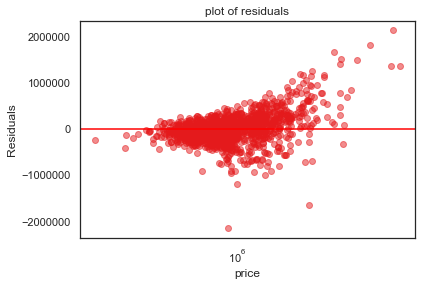

In [1185]:
plt.scatter(x=X_train3.price, y=smf.ols(formula=formula, 
                                        data=X_train3).fit().resid, alpha = 0.5)
plt.title("plot of residuals")
plt.axhline(color='r')
plt.ylabel("Residuals")
plt.xlabel("price")
plt.xscale("log");

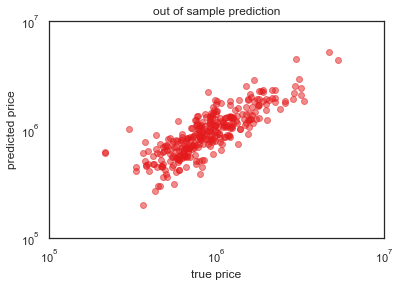

In [1186]:

y_pred3 = smf.ols(formula=formula, 
                  data=X_train3).fit().predict(X_test3)
plt.scatter(x=y_test3, y=y_pred3, alpha = 0.5)
plt.ylabel("predicted price")
plt.xlabel("true price")
plt.title("out of sample prediction")
plt.xscale("log")
plt.yscale("log")
plt.ylim(100000,10000000)
plt.xlim(100000,10000000);

In [1187]:
print("Mean Error (less is better):" + str(np.sqrt(mean_squared_error(y_test3, y_pred3))))
print("R2 score (closer to 1 is better):" + str(r2_score(y_test3, y_pred3)))

print("proportion of error to price mean:"+str((np.sqrt(mean_squared_error(y_test3, y_pred3))/
                                                df_clean[df_clean["zip_ranks"] >= sorted(list(df_clean.zip_ranks.unique()))[-10]].price.mean()*100)))

Mean Error (less is better):336466.4064919336
R2 score (closer to 1 is better):0.7232796649010348
proportion of error to price mean:32.24333034481864


## Prediction for new homes in expensive zip codes

In [1188]:
y = best_areas.query("yr_since_renov <= 10").price
X_train4, X_test4, y_train4, y_test4 = train_test_split(best_areas.query("yr_since_renov <= 10"), y, test_size=0.2)

In [1189]:
cols = list(df_clean.columns)
cols.append("")
cols.pop(cols.index("price"))
cols.pop(cols.index("zip_ranks"))
cols.pop(cols.index("renov_bins"))
cols.pop(cols.index("yr_built"))
cols.pop(cols.index("yr_since_renov"))
nkey = ""
formula = "price ~ "
formula_list = []
n=0
while len(cols) > 0:
    formula += nkey + " + "
    cols.pop(cols.index(nkey))
    a = {elm : smf.ols(formula=formula+ " "+elm, data=X_train4).fit().rsquared_adj for elm in cols}
    for key, value in a.items():
        if  value == max(a.values()):
            nkey = key
            formula_list.append(key)
            print(str(n) + ":"+key + ": rsquared_adj: " + str(value))
            n+=1

0:sqft_living: rsquared_adj: 0.6968765824540175
1:Grade_11: rsquared_adj: 0.7150349792592539
2:waterfront: rsquared_adj: 0.7318630055382827
3:sqft_living15: rsquared_adj: 0.7453941199583003
4:sqft_basement: rsquared_adj: 0.7537777619614311
5:Grade_7: rsquared_adj: 0.7600201352505694
6:Grade_10: rsquared_adj: 0.7634712590360954
7:Grade_12: rsquared_adj: 0.7686522423075951
8:sqft_lot: rsquared_adj: 0.7709663694625808
9:floors: rsquared_adj: 0.77540750304088
10:bathrooms: rsquared_adj: 0.7763572999359418
11:br_br_ratio: rsquared_adj: 0.776866968436302
12:sqft_above: rsquared_adj: 0.776866968436302
13:Grade_4: rsquared_adj: 0.776866968436302
14:Grade_5: rsquared_adj: 0.776866968436302
15:Grade_6: rsquared_adj: 0.776866968436302
16:Grade_13: rsquared_adj: 0.776866968436302
17:condition_2: rsquared_adj: 0.776866968436302
18:condition_5: rsquared_adj: 0.776866968436302
19:Grade_4: rsquared_adj: 0.7768669684363021
20:Grade_5: rsquared_adj: 0.7768669684363021
21:Grade_6: rsquared_adj: 0.7768669

In [1190]:
formula = "price ~ "+" + ".join(formula_list[0:10])
print(formula)

price ~ sqft_living + Grade_11 + waterfront + sqft_living15 + sqft_basement + Grade_7 + Grade_10 + Grade_12 + sqft_lot + floors


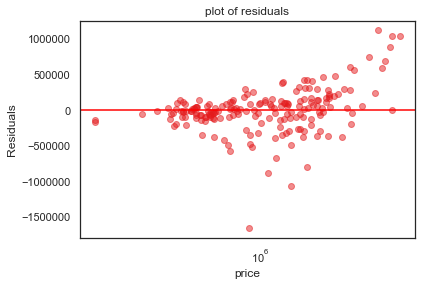

In [1191]:
plt.scatter(x=X_train4.price, y=smf.ols(formula=formula, 
                                        data=X_train4).fit().resid, alpha = 0.5)
plt.title("plot of residuals")
plt.axhline(color='r')
plt.ylabel("Residuals")
plt.xlabel("price")
plt.xscale("log");

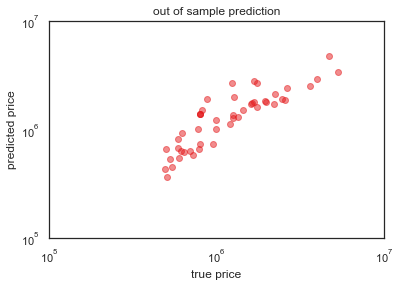

In [1192]:
y_pred4 = smf.ols(formula=formula, 
                  data=X_train4).fit().predict(X_test4)
plt.scatter(x=y_test4, y=y_pred4, alpha = 0.5)
plt.ylabel("predicted price")
plt.xlabel("true price")
plt.title("out of sample prediction")
plt.xscale("log")
plt.yscale("log")
plt.ylim(100000,10000000)
plt.xlim(100000,10000000);

In [1193]:
print("Mean Error (less is better):" + str(np.sqrt(mean_squared_error(y_test3, y_pred3))))
print("R2 score (closer to 1 is better):" + str(r2_score(y_test3, y_pred3)))

print("proportion of error to price mean:"+str((np.sqrt(mean_squared_error(y_test3, y_pred3))/
                                                best_areas.query("yr_since_renov <= 10").price.mean()*100)))

Mean Error (less is better):336466.4064919336
R2 score (closer to 1 is better):0.7232796649010348
proportion of error to price mean:26.939485739421386


# 7. Visualization

In [1194]:
df_clean.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'sqft_above', 'sqft_basement', 'yr_built',
       'sqft_living15', 'sqft_lot15', 'yr_since_renov', 'br_br_ratio',
       'zip_ranks', 'good_quality', 'Grade_4', 'Grade_5', 'Grade_6', 'Grade_7',
       'Grade_8', 'Grade_9', 'Grade_10', 'Grade_11', 'Grade_12', 'Grade_13',
       'condition_2', 'condition_3', 'condition_4', 'condition_5',
       'renov_bins'],
      dtype='object')

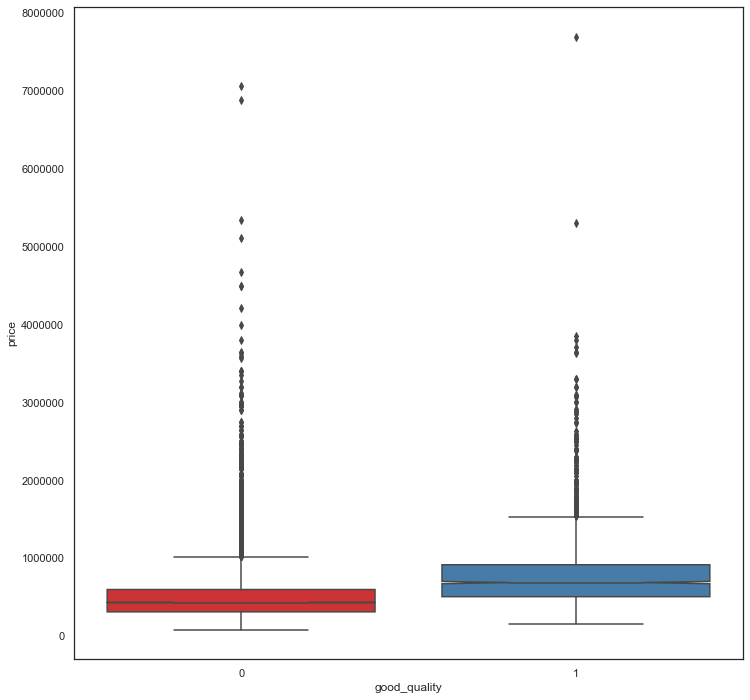

In [1196]:
plt.figure (figsize=(12,12))
sns.boxplot(x=df_clean.good_quality,y=df_clean.price, notch = True)
#plt.yscale("log");

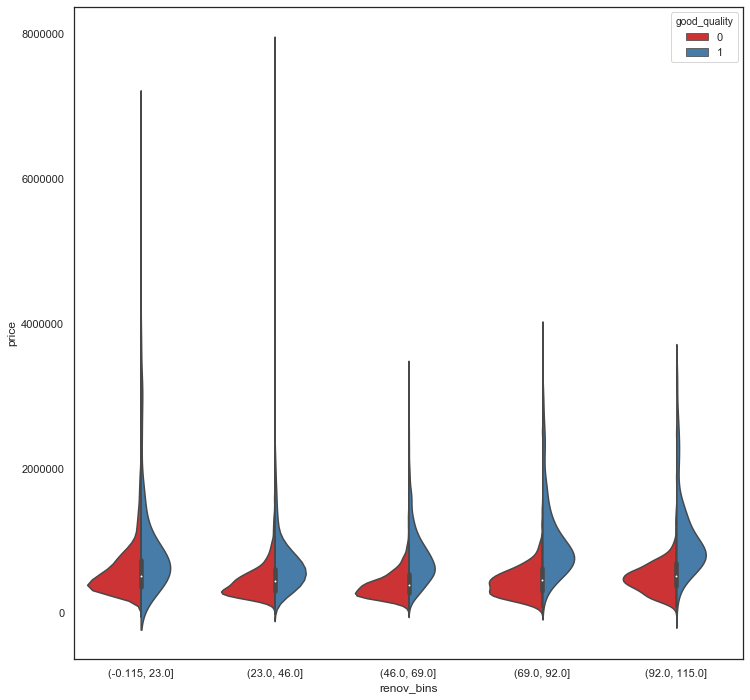

In [1197]:
plt.figure (figsize=(12,12))
sns.violinplot(x=df_clean.renov_bins,y=df_clean.price, hue=df_clean.good_quality, split = True)
#plt.yscale("log");

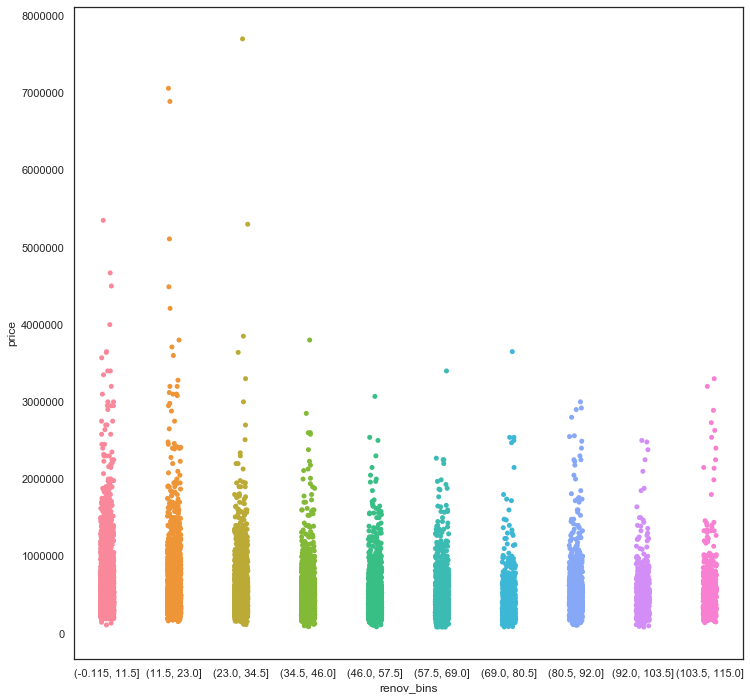

In [928]:
plt.figure (figsize=(12,12))
sns.stripplot(x=df_clean.renov_bins,y=df_clean.price,jitter=True);

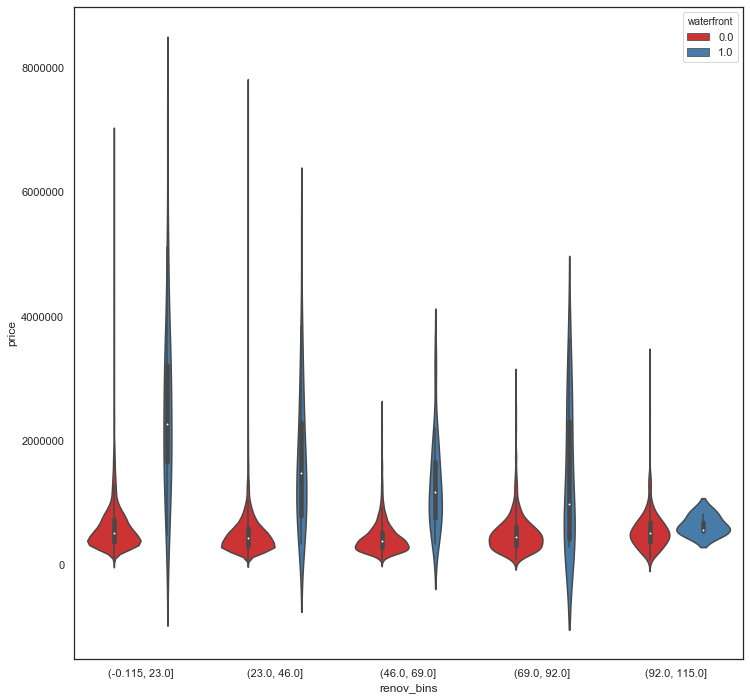

In [959]:
plt.figure (figsize=(12,12))
sns.violinplot(x=df_clean.renov_bins,y=df_clean.price, notch = True, hue=df_clean.waterfront, split=False);

In [910]:
plt.figure (figsize=(12,12))
for i in range(10):
    plt.scatter(y=df_clean[df_clean.renov_bins == sorted(df_clean.renov_bins.unique())[i]].lat,
                x=df_clean[df_clean.renov_bins == sorted(df_clean.renov_bins.unique())[i]].long, 
                label= sorted(df_clean.renov_bins.unique())[i],
                s=10, alpha=0.5)
plt.legend();

AttributeError: 'DataFrame' object has no attribute 'lat'

<Figure size 864x864 with 0 Axes>

In [911]:
plt.figure (figsize=(12,12))



plt.scatter(y=df_clean.query("yr_since_renov > 5").lat,
            x=df_clean.query("yr_since_renov > 5").long, 
            label= "yr_since_renov > 5",
            s=10, alpha=0.5)

plt.scatter(y=df_clean.query("yr_since_renov <= 5").lat,
            x=df_clean.query("yr_since_renov <= 5").long, 
            label= "yr_since_renov <= 5",
            s=10, alpha=0.5)

plt.legend();

AttributeError: 'DataFrame' object has no attribute 'lat'

<Figure size 864x864 with 0 Axes>

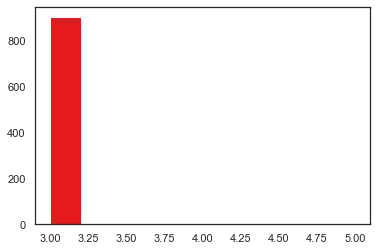

In [634]:
plt.hist(X_train2.condition);

# A. Summary

# B. Future Work

In [ ]:
# wieviel weichen unsere prognosen prozentual von den jeweiligen tatsächlichen preisen ab?